In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

train = pd.read_csv(
    "..\\data\\raw\\hms-harmful-brain-activity-classification\\train.csv"
)
print("Train shape", train.shape)
display(train.head())

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


The formula to convert EEGs to spectrograms is elegantly presented as follows:

<div align="center">

$$
\text{LL Spec} = \text{spec} \left( \frac{(Fp1 - F7) + (F7 - T3) + (T3 - T5) + (T5 - O1)}{4} \right)
$$

</div>

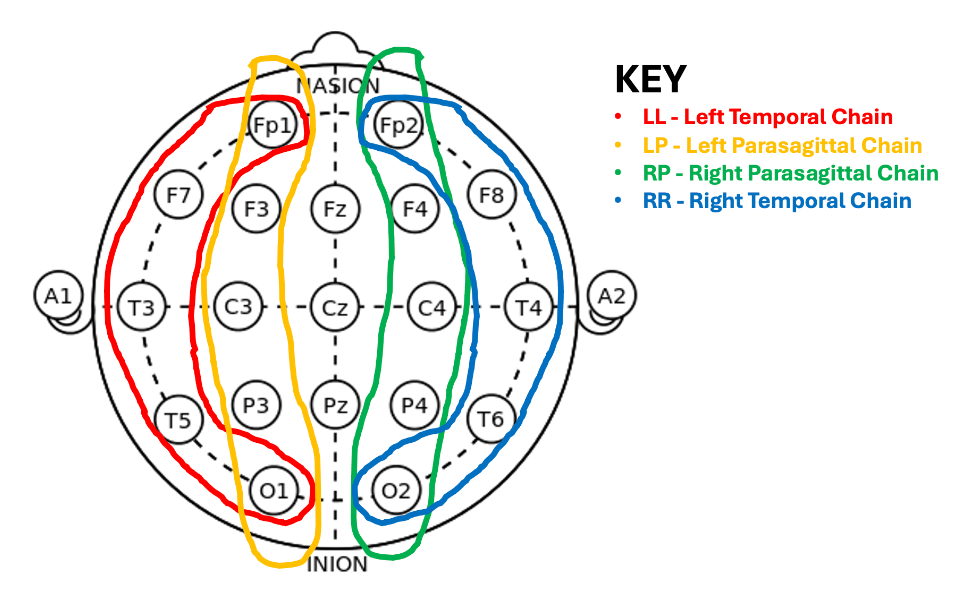


In [2]:
NAMES = ["LL", "LP", "RP", "RR"]

FEATS = [
    ["Fp1", "F7", "T3", "T5", "O1"],
    ["Fp1", "F3", "C3", "P3", "O1"],
    ["Fp2", "F8", "T4", "T6", "O2"],
    ["Fp2", "F4", "C4", "P4", "O2"],
]

directory_path = (
    "..\\data\\processed\\hms-harmful-brain-activity-classification\\EEG_Spectrograms\\"
)
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

### Optional Signal Denoising with Wavelet Transform

In my project, I have the option to denoise the EEG signals before converting them into spectrograms. This optional preprocessing step might help in enhancing the quality of the resulting spectrogram, although it's essential to verify its impact empirically.

I am considering the implementation of a wavelet transform for signal denoising, based on its potential to improve signal clarity:

1. **Denoising Step:** I plan to apply a wavelet transform to the EEG signals. The effectiveness of denoising can be significantly influenced by the choice of the wavelet.
2. **Wavelet Selection:** Based on recommendations from the community, such as insights shared by Kaggle users, I am inclined to experiment with the `db8` wavelet. This choice is motivated by its proven efficiency in capturing diverse frequency components.

#### Personal Experimentation

- **Exploring Different Wavelets:** Although `db8` comes highly recommended, I intend to test various wavelets to identify the one that best suits my project's needs.
- **Evaluating Spectrogram Quality:** By integrating denoising into my workflow, I aim to meticulously compare the quality of spectrograms generated with and without this step, assessing improvements in detail and clarity.

Adopting this denoising strategy could potentially refine the spectrogram analysis in my project, offering clearer insights into the underlying EEG signals.


In [3]:
import pywt

print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = "db8"  # or anything below

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [4]:
# DENOISE FUNCTION

# Define the function to calculate the Mean Absolute Deviation
def maddest(d, axis=None):
    # Calculate and return the mean of the absolute deviations from the mean
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)


# Define the denoise function with parameters for the signal, wavelet, and decomposition level
def denoise_signal(x, wavelet="haar", level=1):
    # Perform a wavelet decomposition at the specified level
    coeff = pywt.wavedec(x, wavelet, mode="per")

    # Estimate the noise sigma using the median absolute deviation
    sigma = (1 / 0.6745) * maddest(coeff[-level])

    # Calculate the universal threshold
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))

    # Apply the thresholding to each decomposition level beyond the first
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode="hard") for i in coeff[1:])

    # Reconstruct the signal using the thresholded coefficients
    ret = pywt.waverec(coeff, wavelet, mode="per")

    # Return the denoised signal
    return ret

# Creating Spectrograms with Librosa

Utilize the `librosa` library to generate spectrograms, which we will subsequently save to disk. For each `eeg_id`, a single spectrogram will be crafted from the central 50 seconds of data. We limit our analysis to 50-second intervals to ensure consistency with the data available during test inference, where only 50 seconds of EEG are accessible for each `eeg_id`. The dimensions of the generated spectrograms will be 128x256 (frequency x time).

## Main Function

Here is the core function used for generating the spectrograms:

```python
mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256,
                                          n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)
```

### Variable Explanation

- `y`: The input time series signal.
- `sr` (Sampling Frequency): In this specific context, EEG data are sampled 200 times per second.
- `hop_length`: Determines the image width, calculated as `len(x)/hop_length`.
- `n_fft`: Influences the vertical resolution and quality of the spectrogram.
- `n_mels`: Sets the image height, equivalent to `n_mels`.
- `fmin`: Specifies the minimum frequency captured in the spectrogram.
- `fmax`: Defines the maximum frequency included in the spectrogram.
- `win_length`: Affects the horizontal resolution and quality of the spectrogram.

By carefully adjusting these parameters, you can tailor the spectrogram generation to meet the specific requirements of your EEG data analysis, ensuring both accuracy and efficiency.


In [5]:
import librosa


def compute_mel_spectrogram(
    signal, sample_rate=200, hop_length=None, n_fft=1024, n_mels=128, fmin=0, fmax=20
):
    if hop_length is None:
        hop_length = len(signal) // 256
    mel_spec = librosa.feature.melspectrogram(
        y=signal,
        sr=sample_rate,
        hop_length=hop_length,
        n_fft=n_fft,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)
    width = (mel_spec_db.shape[1] // 32) * 32
    return mel_spec_db[:, :width]


def load_eeg_data(parquet_path):
    eeg_data = pd.read_parquet(parquet_path)
    middle_index = (len(eeg_data) - 10_000) // 2
    return eeg_data.iloc[middle_index : middle_index + 10_000]


def prepare_signal(data, cols):
    signals = []
    for i in range(len(cols) - 1):
        signal = data[cols[i]].values - data[cols[i + 1]].values
        signal = np.nan_to_num(signal, nan=np.nanmean(signal))
        signals.append(signal)
    return signals


def spectrogram_from_eeg(parquet_path, feats, use_wavelet=None, display=False):
    eeg_data = load_eeg_data(parquet_path)
    img = np.zeros((128, 256, 4), dtype="float32")

    if display:
        plt.figure(figsize=(10, 7))

    for k, cols in enumerate(feats):
        signals = prepare_signal(eeg_data, cols)
        for signal in signals:
            if use_wavelet:
                signal = denoise_signal(signal, wavelet=use_wavelet)
            mel_spec_db = compute_mel_spectrogram(signal)
            mel_spec_db = (mel_spec_db + 40) / 40
            img[:, :, k] += mel_spec_db

        img[:, :, k] /= len(signals)

        if display:
            plt.subplot(2, 2, k + 1)
            plt.imshow(img[:, :, k], aspect="auto", origin="lower")
            plt.title(f"Spectrogram {k}")

    if display:
        plt.show()

    return img

In [6]:
%%time
PATH = "..\\data\\raw\\hms-harmful-brain-activity-classification\\train_eegs\\"
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
all_eegs = {}

for i, eeg_id in enumerate(EEG_IDS):
    if (i % 100 == 0) & (i != 0):
        print(i, ", ", end="")

    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f"{PATH}{eeg_id}.parquet", i < DISPLAY)

    # SAVE TO DISK
    if i == DISPLAY:
        print(f"Creating and writing {len(EEG_IDS)} spectrograms to disk... ", end="")
    np.save(f"{directory_path}{eeg_id}", img)
    all_eegs[eeg_id] = img

# SAVE EEG SPECTROGRAM DICTIONARY
np.save("eeg_specs", all_eegs)

TypeError: 'bool' object is not iterable